Using device: cuda
Files already downloaded and verified


Training GAN: 100%|██████████| 3/3 [03:22<00:00, 67.59s/it, D Loss=0.583, G Loss=3.41]



XAIDetector on ε=0.05


Training XAIDetector: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s, Loss=0.571]


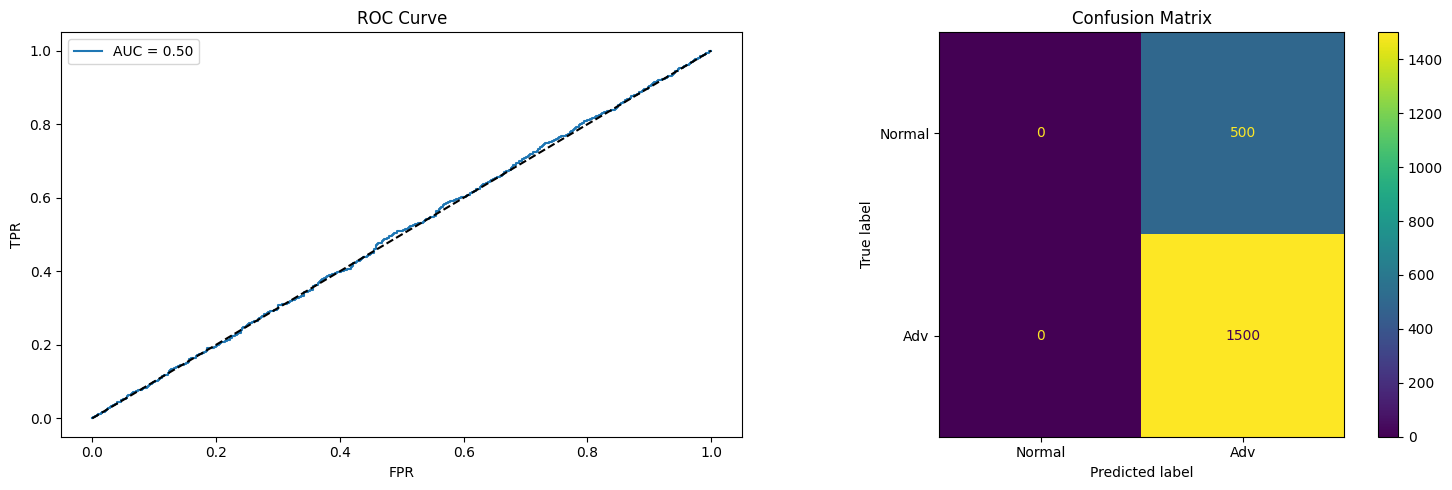

Evaluation for ALL attack (ε=0.05):
AUROC: 0.5026, Accuracy: 0.7500, FID: 1586.5311

Baseline Detector on ε=0.05


Training BaselineDetector: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s, Loss=0.675]


Baseline Detector: AUROC: 0.5000, Accuracy: 0.5855

XAIDetector on ε=0.1


Training XAIDetector: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s, Loss=0.57] 


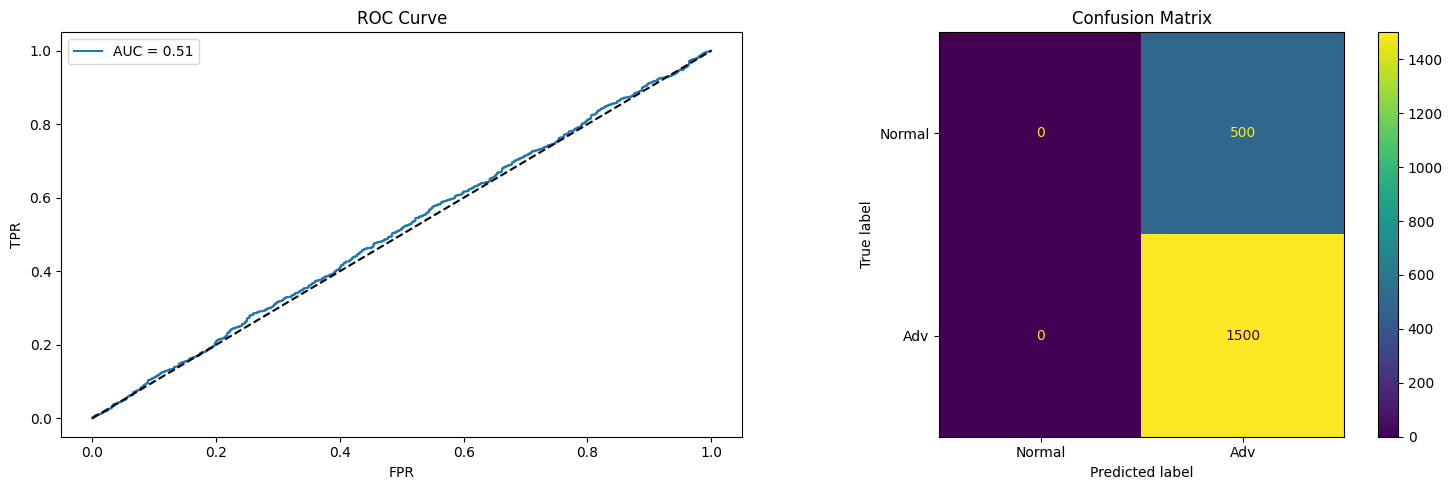

Evaluation for ALL attack (ε=0.1):
AUROC: 0.5100, Accuracy: 0.7500, FID: 1594.2001

Baseline Detector on ε=0.1


Training BaselineDetector: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s, Loss=0.631]


Baseline Detector: AUROC: 0.4999, Accuracy: 0.7155

XAIDetector on ε=0.2


Training XAIDetector: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s, Loss=0.568]


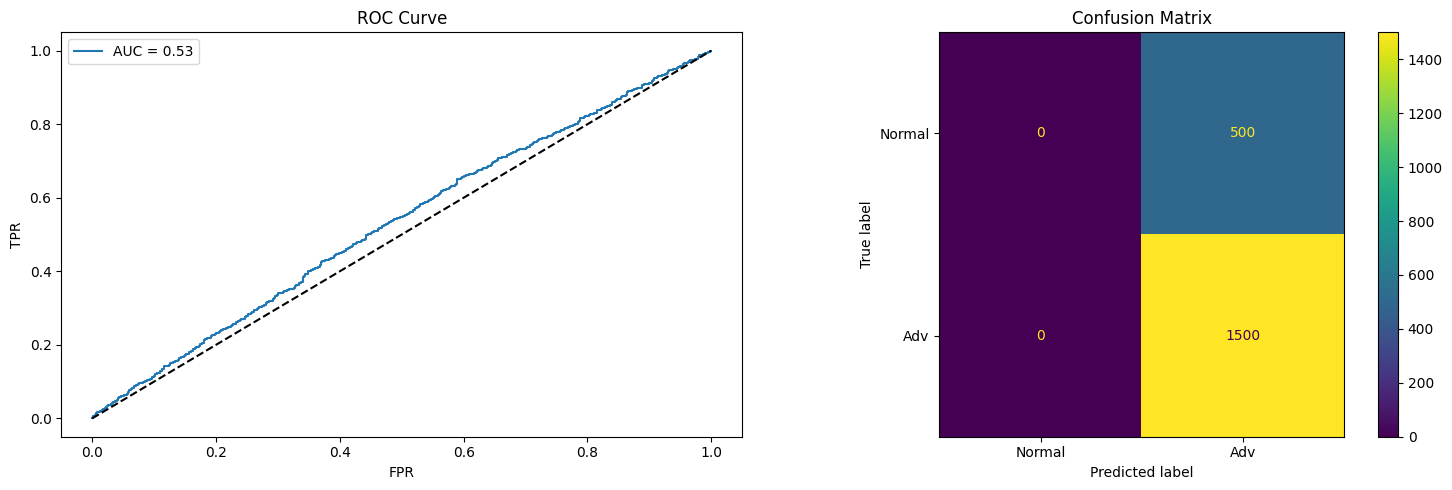

Evaluation for ALL attack (ε=0.2):
AUROC: 0.5307, Accuracy: 0.7500, FID: 1570.3001

Baseline Detector on ε=0.2


Training BaselineDetector: 100%|██████████| 3/3 [00:00<00:00,  4.52it/s, Loss=0.604]


Baseline Detector: AUROC: 0.5025, Accuracy: 0.7490

Comparison (XAIDetector vs. Baseline Detector):
XAIDetector: AUROC = 0.5144 ± 0.0119, Accuracy = 0.7500 ± 0.0000, FID = 1583.6771 ± 9.9637
Baseline Detector: AUROC = 0.5008 ± 0.0012, Accuracy = 0.6833 ± 0.0705
t-test for AUROC:
t-stat = 1.6096, p-value = 0.1828
Mann-Whitney U test for AUROC:
U-stat = 9.0000, p-value = 0.1000
Evaluating on standard attacks:


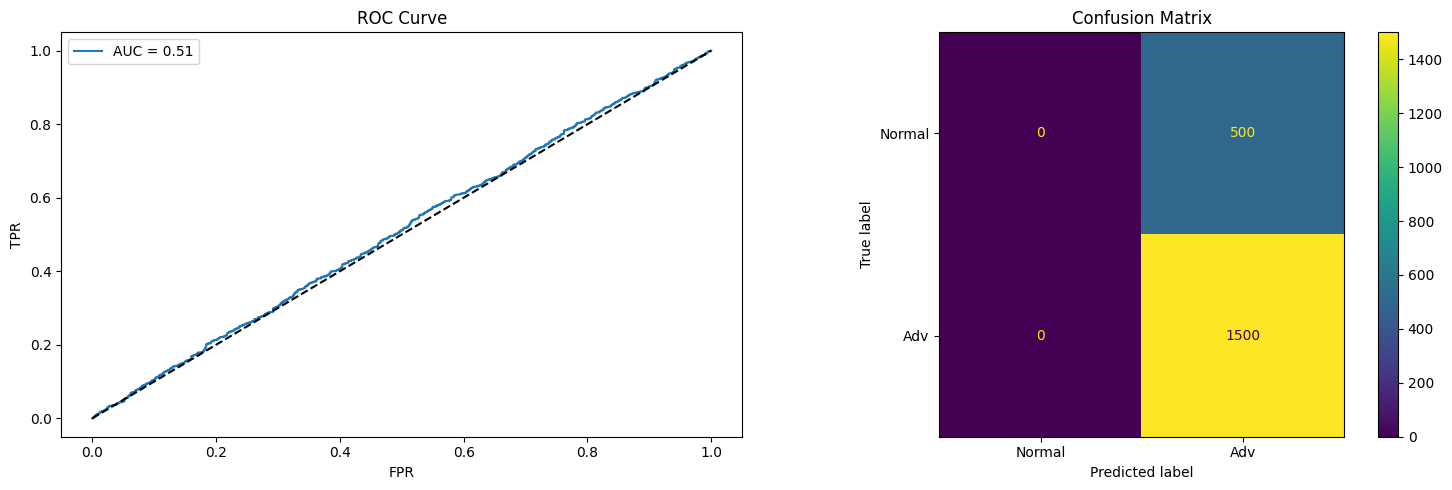

Evaluation for ALL attack (ε=0.1):
AUROC: 0.5095, Accuracy: 0.7500, FID: 1627.4258
Evaluating on adaptive attack:


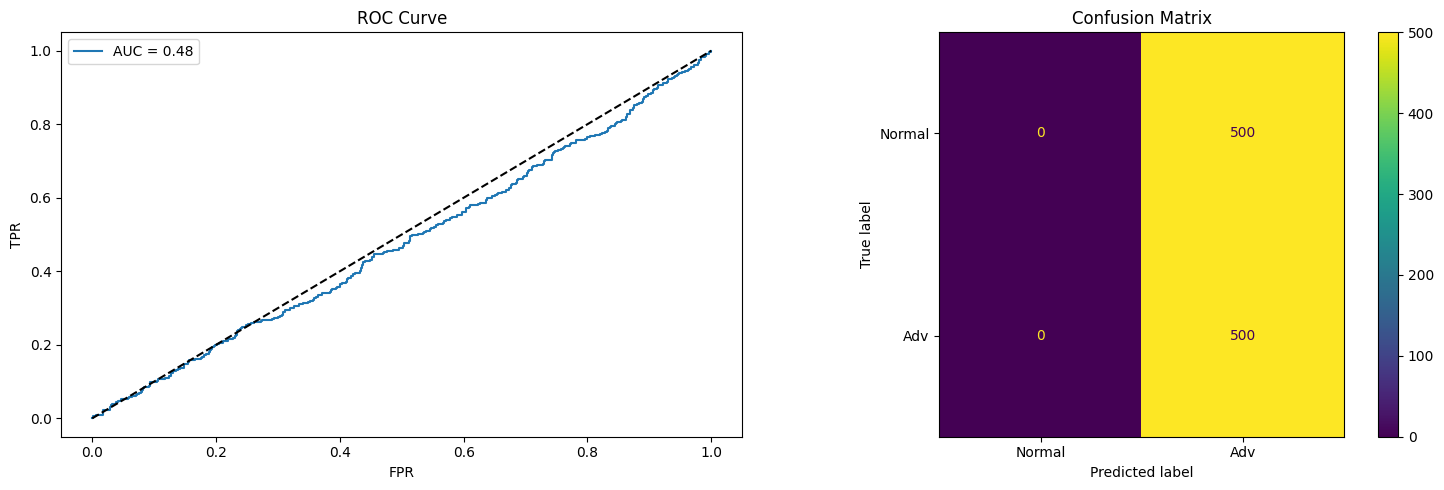

Evaluation for ALL attack (ε=0.1 adaptive):
AUROC: 0.4774, Accuracy: 0.5000, FID: 1744.0976


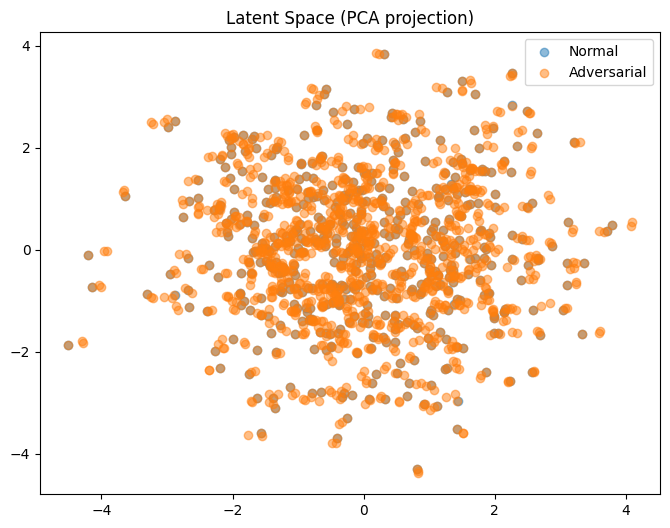

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93593925..0.9082626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9616349..0.96490055].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9582348..0.9673683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93580276..0.9080933].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8979653..0.83568734].


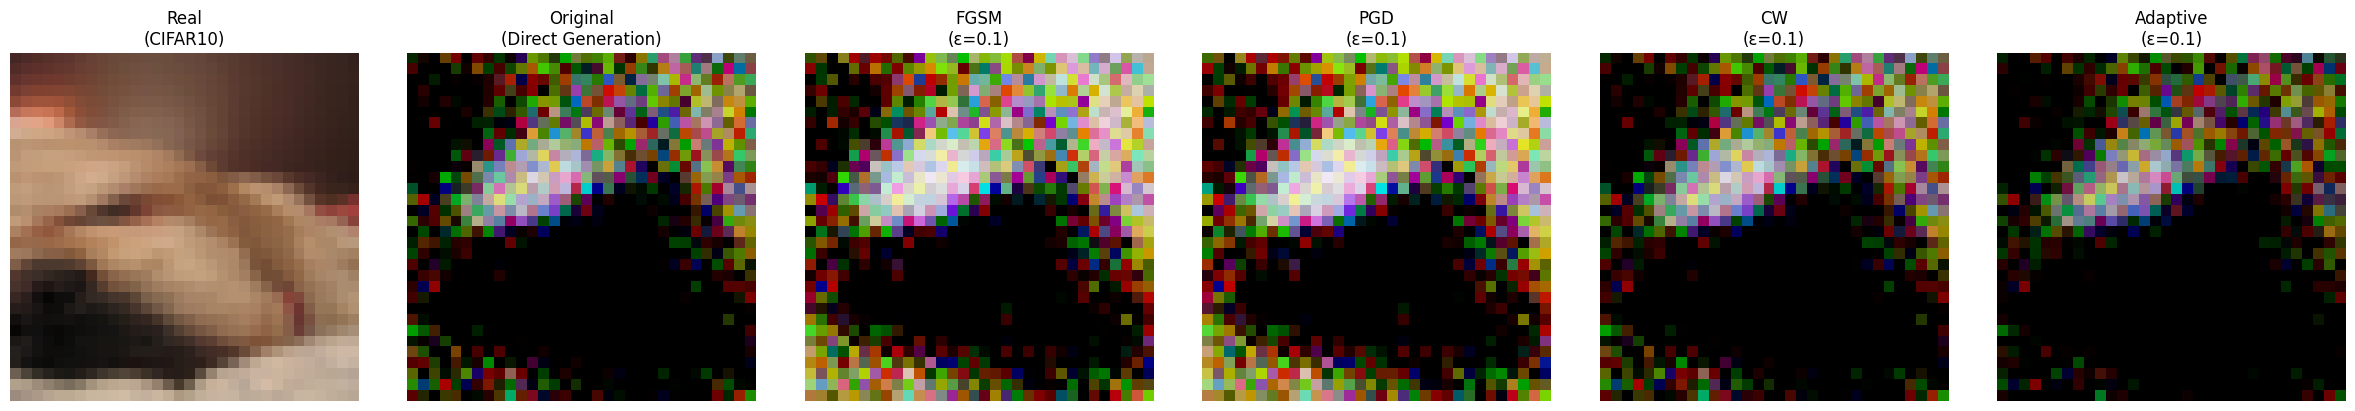


Training MagNet Detector...


Training MagNet: 100%|██████████| 3/3 [01:05<00:00, 21.70s/it, Loss=0.00407]


Average reconstruction error (MagNet) on a batch: 0.003109597135335207


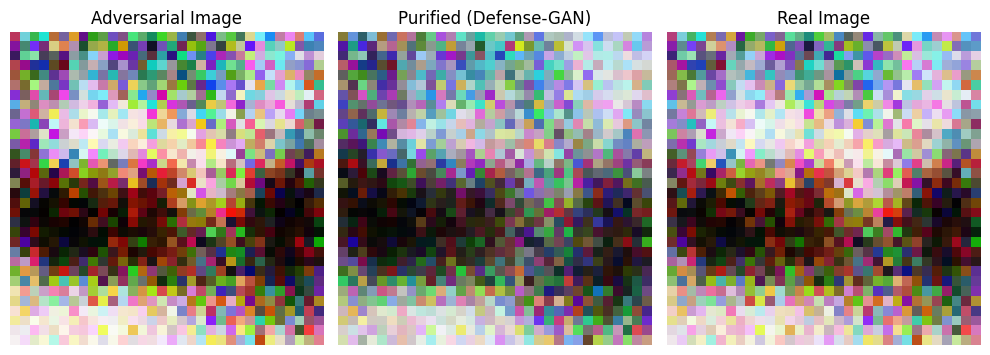


Training LatentExplainer...
[LatentExplainer Epoch 1] Loss: 0.9096
[LatentExplainer Epoch 2] Loss: 0.7582
[LatentExplainer Epoch 3] Loss: 0.7170
[LatentExplainer Epoch 4] Loss: 0.7001
[LatentExplainer Epoch 5] Loss: 0.6894
[LatentExplainer Epoch 6] Loss: 0.6800
[LatentExplainer Epoch 7] Loss: 0.6732
[LatentExplainer Epoch 8] Loss: 0.6683
[LatentExplainer Epoch 9] Loss: 0.6651
[LatentExplainer Epoch 10] Loss: 0.6630

Training LatentVAE...
[LatentVAE Epoch 1] Loss: 1.0224
[LatentVAE Epoch 2] Loss: 1.0049
[LatentVAE Epoch 3] Loss: 1.0013
[LatentVAE Epoch 4] Loss: 1.0001
[LatentVAE Epoch 5] Loss: 0.9992
[LatentVAE Epoch 6] Loss: 0.9990
[LatentVAE Epoch 7] Loss: 0.9985
[LatentVAE Epoch 8] Loss: 0.9982
[LatentVAE Epoch 9] Loss: 0.9981
[LatentVAE Epoch 10] Loss: 0.9980


In [ ]:
# Cell 1: Installations (if needed)
# !pip install torch torchvision tqdm matplotlib sklearn scipy

# Cell 2: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import save_image

from torchvision.models import resnet18, ResNet18_Weights

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from scipy import linalg
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 
                      'cpu')
print(f"Using device: {device}")

# Cell 3: Hyperparameters and Dataset Choice
class Config:
    latent_dim = 100
    batch_size = 16
    lr = 0.0002
    epochs = 3
    epsilon_values = [0.05, 0.1, 0.2]   # benchmark across different epsilon values
    attack_types = ['fgsm', 'pgd', 'cw']
    detector_threshold = 0.5  # base threshold (will be adapted)
    runs_for_stats = 5
    dataset = 'cifar10'   # Options: 'mnist' or 'cifar10'

config = Config()

if config.dataset == 'cifar10':
    img_channels = 3
    img_size = 32
else:
    img_channels = 1
    img_size = 28
img_dim = img_channels * img_size * img_size

# Cell 4: Model Architectures

# Generator and Discriminator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(config.latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z).view(-1, img_channels, img_size, img_size)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        return self.main(img.view(-1, img_dim))

# ----------------------------
# Our Proposed Detectors
# ----------------------------

# 1. XAIDetector (Original version)
class XAIDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(config.latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.main(z)

# 2. Baseline Detector (Logistic regression on latent codes)
class BaselineDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(config.latent_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.linear(z)

# 3. MagNet Detector (Autoencoder-based on images)
class MagNetDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, img):
        z = self.encoder(img)
        recon = self.decoder(z)
        return recon
    def reconstruction_error(self, img):
        recon = self.forward(img)
        error = ((img - recon)**2).mean(dim=[1,2,3])
        return error

# ----------------------------
# New Modules for Novel Extensions
# ----------------------------

# (A) LatentExplainer (Autoencoder-style Explainer for latent vectors)
class LatentExplainer(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    def forward(self, z):
        encoded = self.encoder(z)
        decoded = self.decoder(encoded)
        return decoded

# (B) Variational Autoencoder (VAE) for Manifold Analysis of latent vectors
class LatentVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc_mu = nn.Linear(64, 32)
        self.fc_logvar = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, latent_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ----------------------------
# Attacker (Includes adaptive attack using the detector)
# ----------------------------
class GANAttacker:
    def __init__(self, G, D, detector=None):
        self.G = G
        self.D = D
        self.detector = detector  # For adaptive attack; attacker has access
    def fgsm(self, z, epsilon=0.1):
        z = z.clone().detach().requires_grad_(True)
        gen_img = self.G(z)
        d_out = self.D(gen_img)
        loss_fn = nn.BCELoss(reduction='mean')
        loss = loss_fn(d_out, torch.ones_like(d_out))
        loss.backward()
        adv_z = z + epsilon * z.grad.sign()
        return adv_z.detach()
    def pgd(self, z, epsilon=0.1, alpha=0.01, iterations=10):
        adv_z = z.clone().detach()
        for i in range(iterations):
            adv_z = adv_z.clone().detach().requires_grad_(True)
            gen_img = self.G(adv_z)
            d_out = self.D(gen_img)
            loss_fn = nn.BCELoss(reduction='mean')
            loss = loss_fn(d_out, torch.ones_like(d_out))
            loss.backward()
            with torch.no_grad():
                adv_z = adv_z + alpha * adv_z.grad.sign()
                adv_z = torch.clamp(adv_z, z - epsilon, z + epsilon)
        return adv_z.detach()
    def cw(self, z, iterations=100, epsilon=0.1):
        confidence = epsilon * 100
        z_adv = z.clone().detach().requires_grad_(True)
        optimizer = optim.Adam([z_adv], lr=0.01)
        for i in range(iterations):
            gen_img = self.G(z_adv)
            d_out = self.D(gen_img)
            loss = -torch.log(d_out + 1e-10) + confidence * torch.norm(z_adv - z, p=2)
            loss = loss.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return z_adv.detach()
    def adaptive_attack(self, z, epsilon=0.1, alpha=0.01, iterations=10):
        lambda_det = 1.0  # weight for detector loss
        z_adv = z.clone().detach()
        for i in range(iterations):
            z_adv = z_adv.clone().detach().requires_grad_(True)
            gen_img = self.G(z_adv)
            d_out = self.D(gen_img)
            loss_gan = nn.BCELoss(reduction='mean')(d_out, torch.ones_like(d_out))
            if self.detector is not None:
                det_out = self.detector(z_adv)
                loss_det = nn.BCELoss(reduction='mean')(det_out, torch.zeros_like(det_out))
            else:
                loss_det = 0.0
            total_loss = loss_gan + lambda_det * loss_det
            total_loss.backward()
            with torch.no_grad():
                z_adv = z_adv - alpha * z_adv.grad.sign()
                z_adv = torch.clamp(z_adv, z - epsilon, z + epsilon)
        return z_adv.detach()

# ----------------------------
# Data Loading & Transformations
# ----------------------------
if config.dataset == 'cifar10':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ])
    dataset_obj = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataset_obj = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset_obj, batch_size=config.batch_size, shuffle=True)

# ----------------------------
# GAN Training
# ----------------------------
def train_gan():
    optimizer_G = optim.Adam(G.parameters(), lr=config.lr)
    optimizer_D = optim.Adam(D.parameters(), lr=config.lr)
    pbar = tqdm(range(config.epochs), desc="Training GAN")
    for epoch in pbar:
        D_losses = []
        G_losses = []
        for real_imgs, _ in train_loader:
            real_imgs = real_imgs.to(device)
            z = torch.randn(real_imgs.size(0), config.latent_dim).to(device)
            # Discriminator step
            real_loss = nn.BCELoss()(D(real_imgs), torch.ones_like(D(real_imgs)))
            fake_imgs = G(z)
            fake_loss = nn.BCELoss()(D(fake_imgs.detach()), torch.zeros_like(D(real_imgs)))
            d_loss = real_loss + fake_loss
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()
            # Generator step
            g_loss = nn.BCELoss()(D(fake_imgs), torch.ones_like(D(real_imgs)))
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()
            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())
        pbar.set_postfix({'D Loss': np.mean(D_losses), 'G Loss': np.mean(G_losses)})

# ----------------------------
# Detector Data Generation Helper Function
# ----------------------------
def generate_detector_data(attack_type='all', epsilon=0.1):
    normal_z = torch.randn(1000, config.latent_dim).to(device)
    adversarial_z = []
    if attack_type == 'all':
        attacks = {
            'fgsm': lambda z: attacker.fgsm(z, epsilon=epsilon),
            'pgd': lambda z: attacker.pgd(z, epsilon=epsilon),
            'cw': lambda z: attacker.cw(z, epsilon=epsilon)
        }
    else:
        attacks = { attack_type: lambda z: getattr(attacker, attack_type)(z, epsilon=epsilon) }
    for attack_name, attack_fn in attacks.items():
        adv_z = torch.cat([attack_fn(z) for z in normal_z.chunk(10)])
        adversarial_z.append(adv_z)
    X = torch.cat([normal_z] + adversarial_z)
    y = torch.cat([torch.zeros(len(normal_z))] + [torch.ones(len(adv)) for adv in adversarial_z]).view(-1, 1).to(device)
    return X, y

# ----------------------------
# Training functions for detectors
# ----------------------------
def train_detector(detector_model, attack_type='all', epsilon=0.1, epochs=config.epochs):
    X, y = generate_detector_data(attack_type=attack_type, epsilon=epsilon)
    optimizer = optim.Adam(detector_model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    loader = DataLoader(TensorDataset(X, y), batch_size=64, shuffle=True)
    pbar = tqdm(range(epochs), desc=f"Training {detector_model.__class__.__name__}")
    for epoch in pbar:
        epoch_loss = 0
        for batch_X, batch_y in loader:
            outputs = detector_model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        pbar.set_postfix({'Loss': epoch_loss/len(loader)})

def train_baseline_detector(attack_type='all', epsilon=0.1):
    train_detector(baseline_detector, attack_type=attack_type, epsilon=epsilon)

def train_xai_detector(attack_type='all', epsilon=0.1):
    train_detector(detector, attack_type=attack_type, epsilon=epsilon)

# ----------------------------
# New: Training function for LatentExplainer (autoencoder) on clean latents
# ----------------------------
def train_latent_explainer(explainer, epochs=10):
    explainer.train()
    optimizer = optim.Adam(explainer.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    dataset = torch.randn(10000, config.latent_dim).to(device)
    loader = DataLoader(TensorDataset(dataset), batch_size=64, shuffle=True)
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            z = batch[0]
            z_recon = explainer(z)
            loss = criterion(z_recon, z)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[LatentExplainer Epoch {epoch+1}] Loss: {total_loss/len(loader):.4f}")

# ----------------------------
# New: Train VAE for Manifold Analysis
# ----------------------------
def train_latent_vae(vae, epochs=10):
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    # For VAE, the loss is reconstruction loss + KL divergence
    def vae_loss(recon_x, x, mu, logvar):
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss
    dataset = torch.randn(10000, config.latent_dim).to(device)
    loader = DataLoader(TensorDataset(dataset), batch_size=64, shuffle=True)
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x = batch[0]
            recon_x, mu, logvar = vae(x)
            loss = vae_loss(recon_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[LatentVAE Epoch {epoch+1}] Loss: {total_loss/len(loader):.4f}")

# ----------------------------
# Anomaly Detection Functions
# ----------------------------

# (A) Using the latent explainer
def detect_latent_anomalies(explainer, z, threshold=0.1):
    explainer.eval()
    with torch.no_grad():
        z_recon = explainer(z)
        deviation = torch.norm(z - z_recon, dim=1)  # L2 norm deviation
        entropy = -torch.sum(F.softmax(z, dim=1) * F.log_softmax(z, dim=1), dim=1)
        # Combined anomaly score: weight entropy lightly
        anomaly_score = deviation + 0.01 * entropy
        return anomaly_score, anomaly_score > threshold

# (B) Multi-Modal Detection: Combine latent anomaly score with discriminator confidence
def multi_modal_detection(explainer, z, G, D, alpha=0.5, threshold=0.1):
    # alpha: weight for latent anomaly score vs. 1 - discriminator confidence
    explainer.eval()
    with torch.no_grad():
        z_recon = explainer(z)
        deviation = torch.norm(z - z_recon, dim=1)
        entropy = -torch.sum(F.softmax(z, dim=1) * F.log_softmax(z, dim=1), dim=1)
        anomaly_score = deviation + 0.01 * entropy
        gen_imgs = G(z)
        disc_confidence = D(gen_imgs).view(-1)  # ideally 1 for real images
        # Lower discriminator confidence should raise suspicion
        combined_score = alpha * anomaly_score + (1-alpha) * (1 - disc_confidence)
        return combined_score, combined_score > threshold

# (C) Adaptive Thresholding based on average score and epsilon (attack intensity)
def adaptive_threshold(scores, base_threshold=0.1, epsilon=0.1):
    # As an example, adjust threshold linearly based on epsilon and mean score
    mean_score = scores.mean().item()
    adjusted_threshold = base_threshold + epsilon * mean_score
    return adjusted_threshold

# ----------------------------
# Evaluation Metrics and Functions (with quantitative metrics)
# ----------------------------
def compute_fid(real_images, gen_images):
    from torchvision.transforms import Resize
    resize = Resize((299, 299))
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
    model.eval()
    def get_features(x):
        with torch.no_grad():
            if x.size(1) != 3:
                x = x.repeat(1,3,1,1)
            x = resize(x)
            x = model(x)
        return x
    real = torch.tensor(real_images).to(device)
    gen = torch.tensor(gen_images).to(device)
    act1 = get_features(real).view(real.size(0), -1).cpu().numpy()
    act2 = get_features(gen).view(gen.size(0), -1).cpu().numpy()
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

def evaluate_detector(attack_type='all', epsilon=0.1, adaptive=False, use_multi_modal=False, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)
    test_z = torch.randn(500, config.latent_dim).to(device)
    if attack_type == 'all':
        attacks = [attacker.fgsm, attacker.pgd, attacker.cw]
    else:
        attacks = [getattr(attacker, attack_type)]
    if adaptive:
        attacks = [attacker.adaptive_attack]
    all_z = [test_z]
    labels = [torch.zeros(len(test_z))]
    for attack_fn in attacks:
        adv_z = torch.cat([attack_fn(z, epsilon=epsilon) for z in test_z.chunk(10)])
        all_z.append(adv_z)
        labels.append(torch.ones(len(adv_z)))
    X_test = torch.cat(all_z)
    y_test = torch.cat(labels).cpu().numpy()
    
    # Use our latent explainer detector or multi-modal
    if use_multi_modal:
        scores, _ = multi_modal_detection(latent_explainer, X_test, G, D, threshold=0.0)  # threshold is handled below
    else:
        anomaly_score, _ = detect_latent_anomalies(latent_explainer, X_test, threshold=0.0)
        scores = anomaly_score.cpu().numpy()

    # Adjust threshold adaptively
    thresh = adaptive_threshold(torch.tensor(scores), base_threshold=config.detector_threshold, epsilon=epsilon)
    y_pred = (scores > thresh).astype(int)
    auroc = roc_auc_score(y_test, scores)
    acc = accuracy_score(y_test, y_pred)
    
    # Generate images from test_z and real samples for FID
    with torch.no_grad():
        gen_imgs = G(test_z).cpu().numpy()
        real_batch, _ = next(iter(train_loader))
        real_imgs = real_batch[:len(test_z)].cpu().numpy()
        gen_imgs = (gen_imgs + 1)/2.
        real_imgs = (real_imgs + 1)/2.
    fid_score = compute_fid(real_imgs, gen_imgs)
    
    # Visualization: ROC Curve and Confusion Matrix
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    fpr, tpr, _ = roc_curve(y_test, scores)
    ax[0].plot(fpr, tpr, label=f'AUC = {auroc:.2f}')
    ax[0].plot([0,1],[0,1],'k--')
    ax[0].set_xlabel('FPR'); ax[0].set_ylabel('TPR')
    ax[0].set_title('ROC Curve'); ax[0].legend()
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','Adv'])
    disp.plot(ax=ax[1])
    ax[1].set_title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "evaluation_plots.png"))
    plt.show()
    
    print(f"Evaluation for {attack_type.upper()} attack (ε={epsilon}{' adaptive' if adaptive else ''}):")
    print(f"AUROC: {auroc:.4f}, Accuracy: {acc:.4f}, FID: {fid_score:.4f}")
    return auroc, acc, fid_score

def evaluate_baseline_detector(attack_type='all', epsilon=0.1):
    test_z = torch.randn(500, config.latent_dim).to(device)
    if attack_type == 'all':
        attacks = [attacker.fgsm, attacker.pgd, attacker.cw]
    else:
        attacks = [getattr(attacker, attack_type)]
    all_z = [test_z]
    labels = [torch.zeros(len(test_z))]
    for attack_fn in attacks:
        adv_z = torch.cat([attack_fn(z, epsilon=epsilon) for z in test_z.chunk(10)])
        all_z.append(adv_z)
        labels.append(torch.ones(len(adv_z)))
    X_test = torch.cat(all_z)
    y_test = torch.cat(labels).cpu().numpy()
    with torch.no_grad():
        scores = baseline_detector(X_test).cpu().numpy().flatten()
    auroc = roc_auc_score(y_test, scores)
    y_pred = (scores > config.detector_threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    print(f"Baseline Detector: AUROC: {auroc:.4f}, Accuracy: {acc:.4f}")
    return auroc, acc

# ----------------------------
# Visualization of Latent Space Distributions
# ----------------------------
def visualize_latent_space():
    normal_z = torch.randn(500, config.latent_dim).cpu().numpy()
    adv_z = []
    for attack_fn in [attacker.fgsm, attacker.pgd, attacker.cw]:
        adv_z_part = torch.cat([attack_fn(z, epsilon=0.1) for z in torch.tensor(normal_z).to(device).chunk(10)]).cpu().numpy()
        adv_z.append(adv_z_part)
    adv_z = np.concatenate(adv_z, axis=0)
    labels = np.hstack([np.zeros(len(normal_z)), np.ones(len(adv_z))])
    codes = np.vstack([normal_z, adv_z])
    pca = PCA(n_components=2)
    proj = pca.fit_transform(codes)
    plt.figure(figsize=(8,6))
    plt.scatter(proj[labels==0,0], proj[labels==0,1], label="Normal", alpha=0.5)
    plt.scatter(proj[labels==1,0], proj[labels==1,1], label="Adversarial", alpha=0.5)
    plt.title("Latent Space (PCA projection)")
    plt.legend()
    plt.show()

# ----------------------------
# Robustness Analysis against Adaptive Attacks
# ----------------------------
def robustness_analysis_adaptive(epsilon=0.1):
    print("Evaluating on standard attacks:")
    metrics_standard = evaluate_detector(attack_type='all', epsilon=epsilon, adaptive=False)
    print("Evaluating on adaptive attack:")
    metrics_adaptive = evaluate_detector(attack_type='all', epsilon=epsilon, adaptive=True)
    return metrics_standard, metrics_adaptive

# ----------------------------
# Visualization of Attack Examples
# ----------------------------
def visualize_attacks(epsilon=0.1):
    G.eval()
    z = torch.randn(1, config.latent_dim).to(device)
    real_batch, _ = next(iter(train_loader))
    real_img = real_batch[0]
    attacks = {
        "Real": "real",
        "Original": None,
        "FGSM": attacker.fgsm,
        "PGD": attacker.pgd,
        "CW": attacker.cw,
        "Adaptive": attacker.adaptive_attack
    }
    num_plots = len(attacks)
    fig, axs = plt.subplots(1, num_plots, figsize=(4*num_plots, 4))
    
    for idx, (name, attack_fn) in enumerate(attacks.items()):
        if name == "Real":
            # For the real image, get the tensor, scale and convert to numpy.
            img = real_img.cpu().detach().squeeze().numpy()
            img = img * 0.5 + 0.5  # Un-normalize
            title = f"{name}\n({config.dataset.upper()})"
        elif attack_fn is None:
            # For "Original", simply generate an image.
            img = G(z)
            title = f"{name}\n(Direct Generation)"
        else:
            adv_z = attack_fn(z, epsilon=epsilon)
            img = G(adv_z)
            title = f"{name}\n(ε={epsilon})"
        
        # If img is still a tensor, convert to numpy.
        if isinstance(img, torch.Tensor):
            img = img.cpu().detach().squeeze()
            if img.ndim == 3:
                # Convert CHW to HWC
                img = img.permute(1, 2, 0).numpy()
            else:
                img = img.numpy()
        # If img is a numpy array, check its shape and transpose if needed.
        if isinstance(img, np.ndarray) and img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        
        # Decide on colormap if image is grayscale
        if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
            cmap = 'gray'
        else:
            cmap = None
        
        axs[idx].imshow(img, cmap=cmap)
        axs[idx].set_title(title)
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    G.train()

# ----------------------------
# Formal Statistical Tests (for ablation studies)
# ----------------------------
def formal_stat_tests(xid_metrics, baseline_metrics):
    print("t-test for AUROC:")
    tstat, pval = ttest_ind(xid_metrics[:,0], baseline_metrics[:,0])
    print(f"t-stat = {tstat:.4f}, p-value = {pval:.4f}")
    print("Mann-Whitney U test for AUROC:")
    ustat, upval = mannwhitneyu(xid_metrics[:,0], baseline_metrics[:,0])
    print(f"U-stat = {ustat:.4f}, p-value = {upval:.4f}")

# ----------------------------
# Defense-GAN Purification (for comparison)
# ----------------------------
def defense_gan_purify(adversarial_img, G, iterations=100, lr=0.01):
    z = torch.randn(1, config.latent_dim, device=device).requires_grad_(True)
    optimizer = optim.Adam([z], lr=lr)
    target = adversarial_img.detach()
    for i in range(iterations):
        optimizer.zero_grad()
        purified = G(z)
        loss = nn.MSELoss()(purified, target)
        loss.backward()
        optimizer.step()
    return G(z).detach()

def show_tensor_image(img_tensor, title=""):
    img = img_tensor.cpu().detach()
    if img.dim() == 4:
        img = img[0]
    if img.dim() == 3:
        if img.shape[0] == 1:
            img = img.squeeze(0)
            plt.imshow(img.numpy() * 0.5 + 0.5, cmap='gray')
        else:
            img = img.permute(1, 2, 0)
            plt.imshow(img.numpy() * 0.5 + 0.5)
    elif img.dim() == 2:
        plt.imshow(img.numpy() * 0.5 + 0.5, cmap='gray')
    else:
        raise ValueError(f"Unsupported tensor shape: {img.shape}")
    plt.title(title)
    plt.axis("off")

# ----------------------------
# Initialize Models, Detectors, Explainers, and Attacker
# ----------------------------
G = Generator().to(device)
D = Discriminator().to(device)
detector = XAIDetector().to(device)
baseline_detector = BaselineDetector().to(device)
magnet_detector = MagNetDetector().to(device)
attacker = GANAttacker(G, D, detector=detector)

# New modules: latent explainer and VAE
latent_explainer = LatentExplainer(config.latent_dim).to(device)
latent_vae = LatentVAE(config.latent_dim).to(device)

# ----------------------------
# Main Training & Evaluation Pipeline
# ----------------------------
# Train GAN
train_gan()

# Train detectors: XAIDetector and Baseline Detector (for comparison)
results_xid = []
results_baseline = []
for eps in config.epsilon_values:
    print(f"\n{'='*40}\nXAIDetector on ε={eps}\n{'='*40}")
    train_xai_detector(attack_type='all', epsilon=eps)
    metrics = evaluate_detector(attack_type='all', epsilon=eps)
    results_xid.append(metrics)
    
    print(f"\n{'='*40}\nBaseline Detector on ε={eps}\n{'='*40}")
    train_baseline_detector(attack_type='all', epsilon=eps)
    b_metrics = evaluate_baseline_detector(attack_type='all', epsilon=eps)
    results_baseline.append(b_metrics)

results_xid = np.array(results_xid)
results_baseline = np.array(results_baseline)
print("\nComparison (XAIDetector vs. Baseline Detector):")
print("XAIDetector: AUROC = {:.4f} ± {:.4f}, Accuracy = {:.4f} ± {:.4f}, FID = {:.4f} ± {:.4f}".format(
    results_xid[:,0].mean(), results_xid[:,0].std(),
    results_xid[:,1].mean(), results_xid[:,1].std(),
    results_xid[:,2].mean(), results_xid[:,2].std()
))
print("Baseline Detector: AUROC = {:.4f} ± {:.4f}, Accuracy = {:.4f} ± {:.4f}".format(
    results_baseline[:,0].mean(), results_baseline[:,0].std(),
    results_baseline[:,1].mean(), results_baseline[:,1].std()
))
formal_stat_tests(results_xid, results_baseline)
robustness_analysis_adaptive(epsilon=0.1)
visualize_latent_space()
visualize_attacks(epsilon=0.1)

# Train and evaluate MagNet
print("\nTraining MagNet Detector...")
def train_magnet_detector():
    optimizer = optim.Adam(magnet_detector.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    loader = DataLoader(train_loader.dataset, batch_size=64, shuffle=True)
    pbar = tqdm(range(config.epochs), desc="Training MagNet")
    for epoch in pbar:
        epoch_loss = 0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            recon = magnet_detector(imgs)
            loss = criterion(recon, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        pbar.set_postfix({'Loss': epoch_loss/len(loader)})
train_magnet_detector()
real_batch, _ = next(iter(train_loader))
imgs = real_batch.to(device)
with torch.no_grad():
    rec_err = magnet_detector.reconstruction_error(imgs)
print("Average reconstruction error (MagNet) on a batch:", rec_err.mean().item())

# Defense-GAN Purification demonstration
z = torch.randn(1, config.latent_dim).to(device)
G.eval()
real_img = G(z)
z_adv_example = attacker.fgsm(z, epsilon=0.1)
adv_img = G(z_adv_example)
purified_img = defense_gan_purify(adv_img, G, iterations=50, lr=0.01)
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
show_tensor_image(adv_img, title="Adversarial Image")
plt.subplot(1, 3, 2)
show_tensor_image(purified_img, title="Purified (Defense-GAN)")
plt.subplot(1, 3, 3)
show_tensor_image(real_img, title="Real Image")
plt.tight_layout()
plt.show()

# ----------------------------
# New: Train the LatentExplainer and LatentVAE for manifold analysis
# ----------------------------
print("\nTraining LatentExplainer...")
train_latent_explainer(latent_explainer, epochs=10)

print("\nTraining LatentVAE...")
train_latent_vae(latent_vae, epochs=10)


